---
title: "MicroGrad from Scratch with Andrej Karpathy's tutorial"
author: "Jax Bulbrook"
date: "2023-07-25"
categories: [projects]
---

I want to learn how Transformers work in depth, but I need a bit of background first. I am going to do all of the tutorials on Andrej Karpathy's channel, starting with [this micrograd from scratch one](https://www.youtube.com/watch?v=VMj-3S1tku0). That should give me enough background to understand his latest GPT from Scratch tutorial!

In [1]:
class Value:
    def __init__(self,data,_children=(),_op='',label=''): #the data is the value, we need children to store the children passed into functions like add and mult, and op to show the operations that came up with those children.
        self.data = data
        self.grad = 0 # the derivative of L with respect to this value
        self._prev = set(_children)
        self._op = _op
        self.label = label
    def __repr__(self):
        return f"Value(data={self.data})"
    def __add__(self,other):
        out = Value(self.data + other.data, (self,other),"+")
        return out
    def __mul__(self,other):
        out = Value(self.data * other.data, (self,other),"*")
        return out

In [2]:
a = Value(1.5,label='a')
b = Value(-5.5,label='b')
c = Value(0.2,label='c')
a*b,a+b

(Value(data=-8.25), Value(data=-4.0))

In [3]:
e = a*b; e.label = 'e'
d = e+c; d.label = 'd'
f = Value(-2.2,label='f')
L = d*f; L.label = 'L' # the loss function L

In [4]:
d._prev

{Value(data=-8.25), Value(data=0.2)}

In [5]:
d._op

'+'

# Now we want a way to visualize the tree, since there will eventually be many values in the tree.

In [6]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

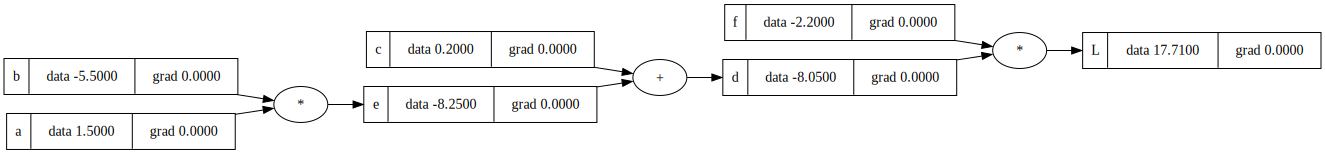

In [7]:
draw_dot(L)

In [8]:
# manual backprop
def lol():
    # the reason this is in a function is because they will be local to this function and therefore not mess up the global scope
    h = 0.001

    a = Value(1.5,label='a')
    b = Value(-5.5,label='b')
    c = Value(0.2,label='c')
    e = a*b; e.label = 'e'
    d = e+c; d.label = 'd'
    f = Value(-2.2,label='f')
    L = d*f; L.label = 'L' # the loss function L
    L1 = L.data

    a = Value(1.5,label='a') 
    b = Value(-5.5,label='b')
    c = Value(0.2,label='c')
    e = a*b; e.label = 'e'
    d = e+c; d.label = 'd'
    f = Value(-2.2,label='f')
    L = d*f; L.label = 'L' # the loss function L
    L2 = L.data + h # the derivate of L with respect to L, since L is increased by h
    print((L2 - L1)/h)
lol()

1.0000000000012221


In [9]:
L.grad = 1

### L = d * f

##### dL/dd =? f (the derivate of L with respect to d is f)

## Proof:
lim h->0 (f(x+h)-f(x))/h

((d+h) * f - d*f)/h
(d*f + h*f - d*f)/h
(h*f)/h
f

In [10]:
d.grad = f.data
f.grad = d.data

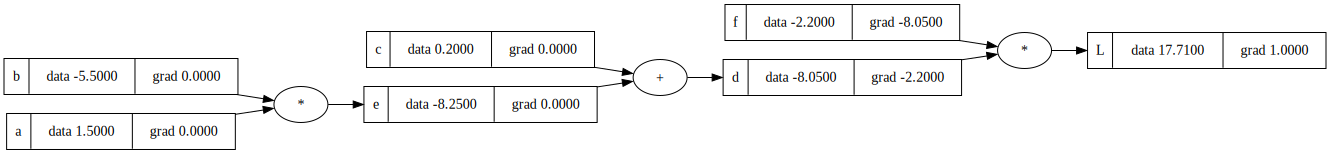

In [11]:
draw_dot(L)

dL / dc 
since we know dL / dd we can get dd / dc and use it to get dL / dc

d = c + e

dd / dc = 1

## Proof
(f(x+h) - f(x)) / h
((c+h + e) - (c + e))/h
(c+h+e-c-e)/h
h/h
1

dd / de = 1 as well

but we need dL / dc
we use the chain rule, which is basically: if a car travels twice as fast as a bicycle and the bicycle is four times as fast as a walking man, then the car travels 2x4=8 times as fast as the man. So you multiply

WANT dL / dc
KNOW dL/dd and dd/dc

dL / dc = (dL / dd) * (dd / dc) = (dL / dd) * 1 = dL / dd

In [12]:
c.grad = d.grad
e.grad = d.grad

dL / da = (dL / de) * (de / da)

de / da?
de / da = b

dL / da = dL / de * b

In [13]:
a.grad = e.grad * b.data
b.grad = e.grad * a.data

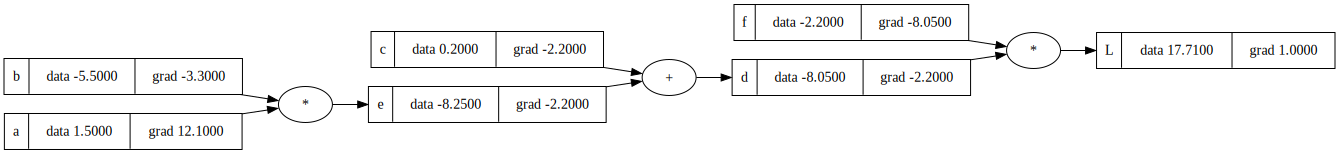

In [14]:
draw_dot(L)

In [15]:
# to try and make L go up, we just have to go in the direction of the gradient
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
d.data += 0.01 * d.grad

e = a * b
d = e + c
L = d * f
print(L.data)

19.3401846


### It worked! Now we will do an example with a neuron
![image.png](https://www.google.com/url?sa=i&url=https%3A%2F%2Fcs231n.github.io%2Fconvolutional-networks%2F&psig=AOvVaw0qCWOtI8RjnVcLCC5vKp0c&ust=1690894863871000&source=images&cd=vfe&opi=89978449&ved=0CBAQjRxqFwoTCPCLva-AuYADFQAAAAAdAAAAABAE)
Here is the activation function:

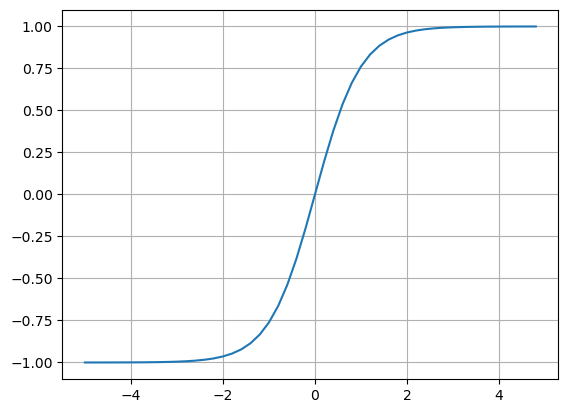

In [16]:
from matplotlib import pyplot as plt
import numpy as np
plt.plot(np.arange(-5,5,.2), np.tanh(np.arange(-5,5,0.2))); plt.grid()

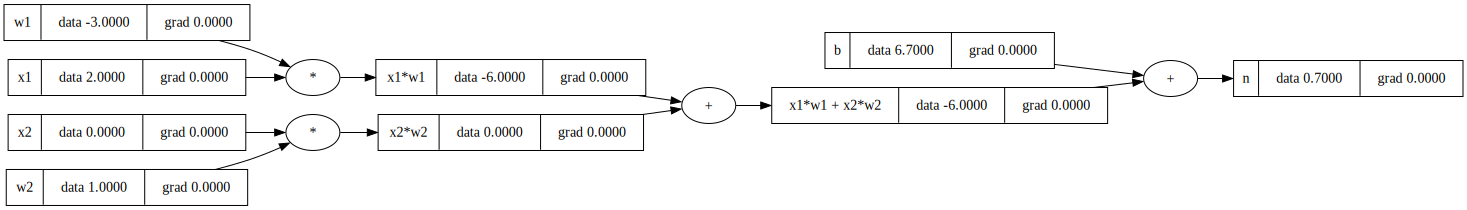

In [17]:
#inputs x1,x2
x1 = Value(2.0,label='x1')
x2 = Value(0.0,label='x2')
# weights w1,w2
w1 = Value(-3, label='w1')
w2 = Value(1,label='w2')
# bias of the neuron
b = Value(6.7, label='b')
#x1*w1 + x2*w2+b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

draw_dot(n)

In [18]:
import math
# in order to do the activation function tanh, we need to update Value
class Value:
    def __init__(self,data,_children=(),_op='',label=''): #the data is the value, we need children to store the children passed into functions like add and mult, and op to show the operations that came up with those children.
        self.data = data
        self.grad = 0 # the derivative of L with respect to this value
        self._prev = set(_children)
        self._op = _op
        self.label = label
    def __repr__(self):
        return f"Value(data={self.data})"
    def __add__(self,other):
        out = Value(self.data + other.data, (self,other),"+")
        return out
    def __mul__(self,other):
        out = Value(self.data * other.data, (self,other),"*")
        return out
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x) + 1)
        out = Value(t,(self, ), 'tanh')
        return out

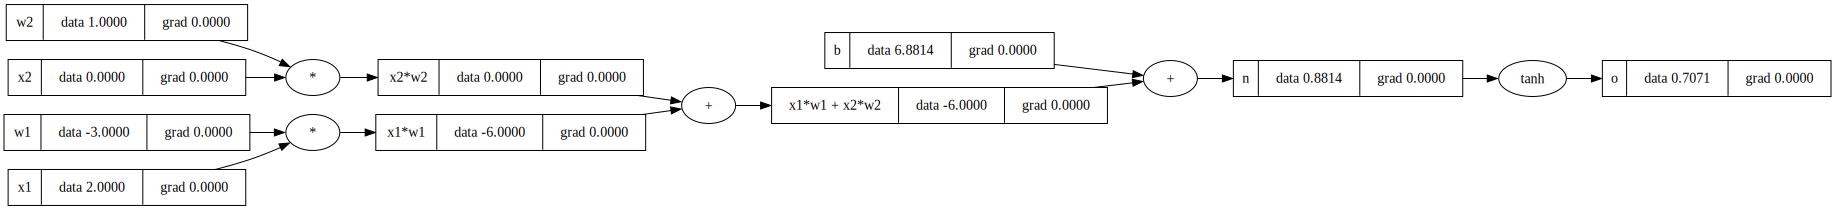

In [19]:
#inputs x1,x2
x1 = Value(2.0,label='x1')
x2 = Value(0.0,label='x2')
# weights w1,w2
w1 = Value(-3, label='w1')
w2 = Value(1,label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
#x1*w1 + x2*w2+b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
draw_dot(o)

In [20]:
o.grad = 1
# o = tanh(n)
# do/dn = 1 - tanh(n)**2
# do/dn = 1 - o**2
n.grad = 1 - o.data**2

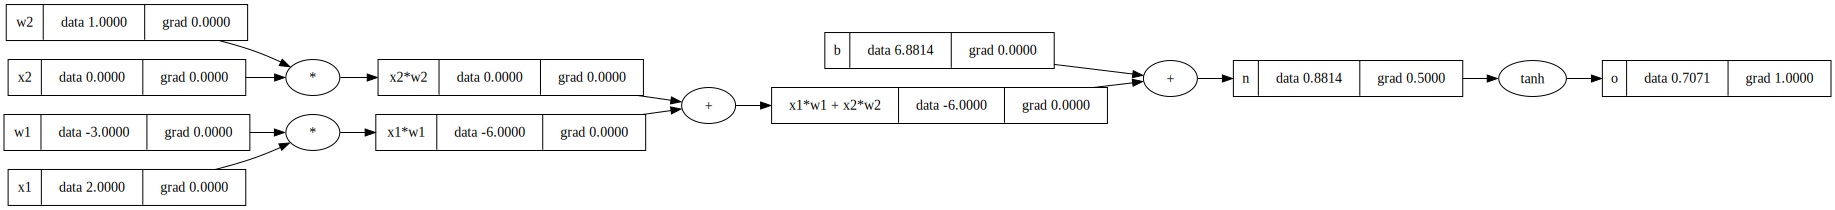

In [21]:
draw_dot(o)

In [22]:
x1w1x2w2.grad = n.grad
b.grad = n.grad

In [23]:
x1w1.grad = x1w1x2w2.grad
x2w2.grad = x1w1x2w2.grad

In [24]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

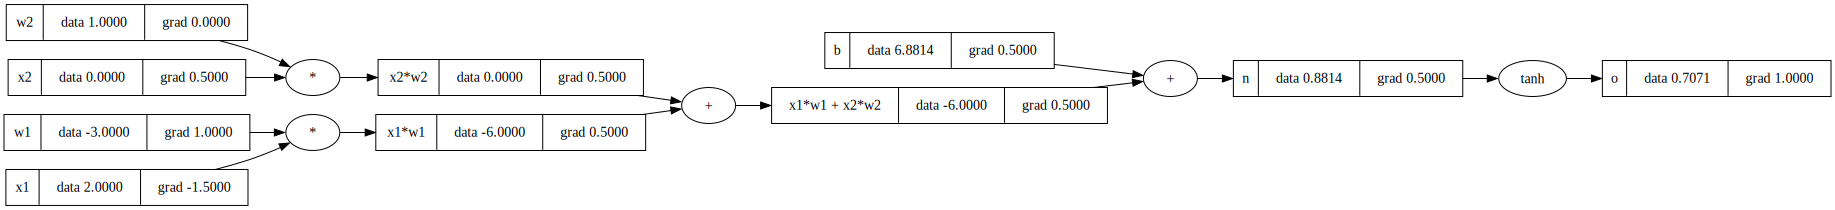

In [25]:
draw_dot(o)

In [65]:
# now to do the backpropogation
class Value:
    def __init__(self,data,_children=(),_op='',label=''): #the data is the value, we need children to store the children passed into functions like add and mult, and op to show the operations that came up with those children.
        self.data = data
        self.grad = 0 # the derivative of L with respect to this value
        self._backward = lambda: None # NEW
        self._prev = set(_children)
        self._op = _op
        self.label = label
    def __repr__(self):
        return f"Value(data={self.data})"
    def __add__(self,other):
        out = Value(self.data + other.data, (self,other),"+")
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    def __mul__(self,other):
        out = Value(self.data * other.data, (self,other),"*")
        def _backward():
            self.grad += out.data * other.grad
            other.grad += out.data * self.grad
        out._backward = _backward
        return out
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x) + 1)
        out = Value(t,(self, ), 'tanh')
        def _backward():
            self.grad = (1 - t**2) * out.grad
        out._backward = _backward
        return out
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(o)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [66]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

In [55]:
o.grad = 1.0 # so that multiplication does not multiply by 0
o._backward()

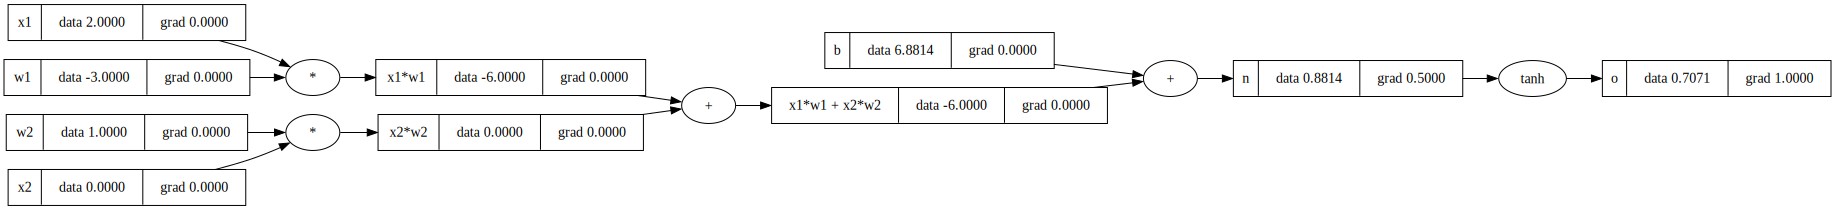

In [56]:
draw_dot(o)

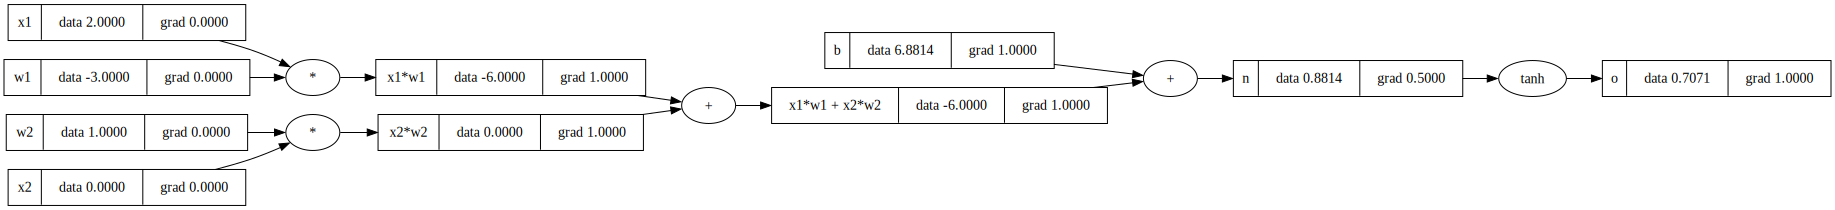

In [57]:
n._backward()
n._backward()
b._backward() #none
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()
draw_dot(o)

In [58]:
# do topological sort
topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)
topo


[Value(data=6.881373587019543),
 Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

In [59]:
o.grad = 1.0
topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)
for node in reversed(topo):
  node._backward()

In [67]:
o.backward()

In [104]:
draw_dot(o)

SyntaxError: invalid decimal literal (2324353414.py, line 1)

In [69]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()


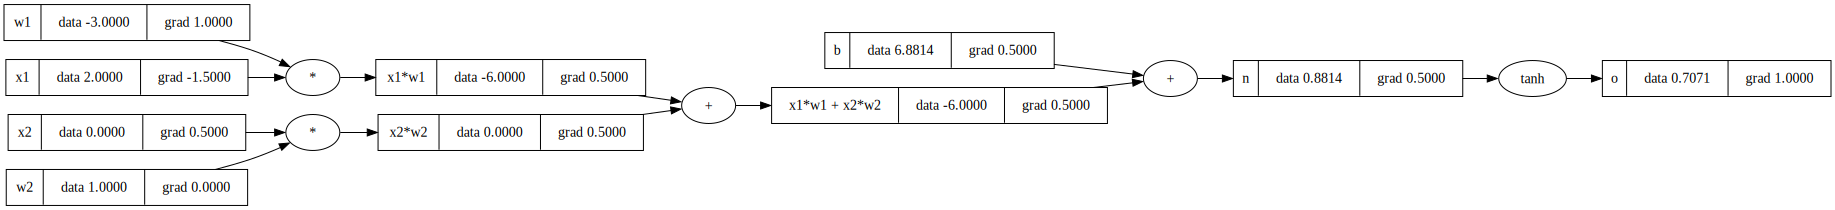

In [70]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

o.backward()
draw_dot(o)

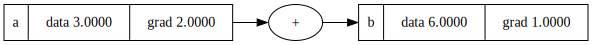

In [71]:
a = Value(3,label='a')
b = a + a; b.label = 'b' # make the gradients do += rather than = so it doesn't override
b.backward()
draw_dot(b)

In [85]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [86]:
a = Value(2)
b = Value(4)
a/b

Value(data=0.5)

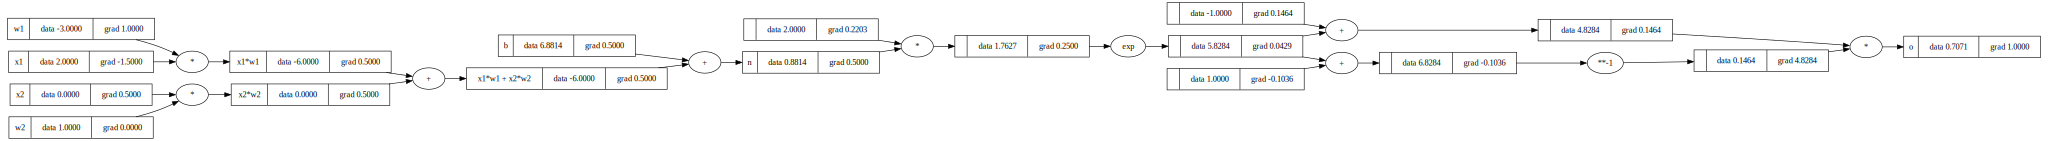

In [87]:
# now with tanh broken up
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ______
e = (2*n).exp()
o = (e - 1)/(e + 1)
# _______
o.label = 'o'
o.backward()
draw_dot(o)

In [89]:
# same thing in PyTorch
import torch

x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())



0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [90]:
import random

In [92]:
# Building a MLP
class Neuron:
    def __init__(self,nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
    def __call__(self,x):
        # w * x + b
        # forward pass
        act = sum((wi*xi for wi,xi in zip(self.w, x)),self.b) # pair up ws with xs
        out = act.tanh()
        return out
x = [2,3]
n = Neuron(2)
n(x)

Value(data=-0.5278816907307129)

In [94]:
class Layer:
    def __init__(self, nin, nout,):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
x = [2,3]
n = Layer(2,3)
n(x)

[Value(data=0.962111430039211),
 Value(data=-0.9934650406307376),
 Value(data=0.3439500937888263)]

In [95]:
class MLP():
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
x = [2,3,-1]
n = MLP(3,[4,4,1])
n(x)

Value(data=-0.057515384626523336)

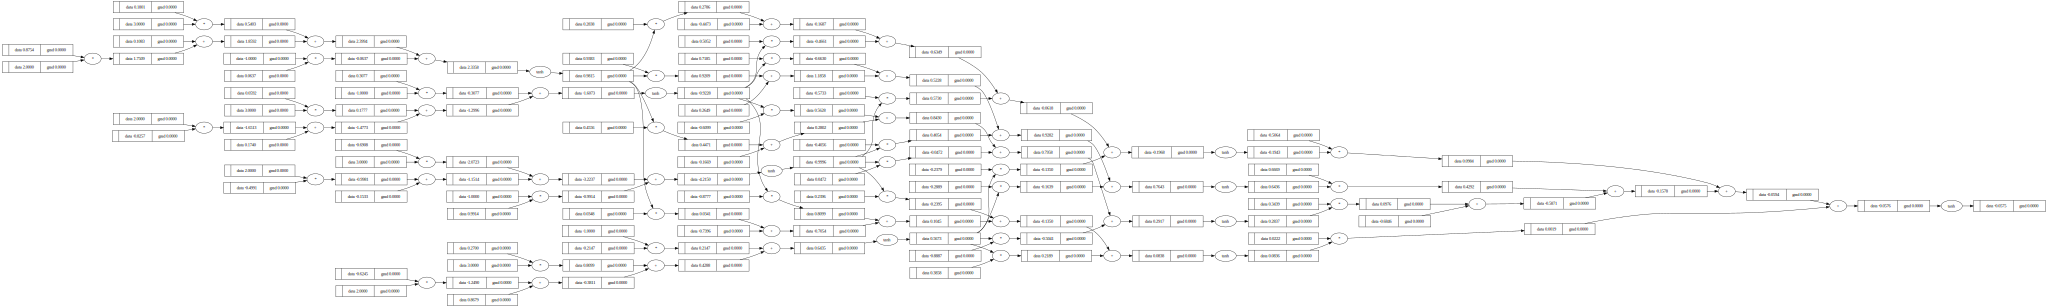

In [96]:
draw_dot(n(x))

In [97]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.057515384626523336),
 Value(data=0.21031897880739908),
 Value(data=-0.23716642272134442),
 Value(data=-0.17695136227658856)]

In [100]:
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys,ypred)])
loss

Value(data=4.550340394971638)

In [101]:
loss.backward()

In [102]:
n.layers[0].neurons[0].w[0].grad

-0.23088023006144023

In [106]:
#draw_dot(loss)